In [66]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

import math

from sklearn.cluster import KMeans
sns.set_theme(style="darkgrid")


In [67]:
pd.options.display.width = 0
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)

In [68]:
def show_kmeans_clusters(data, x, y, hue, kmeans, title):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8, 8))
    
    scat = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        palette="Set2",
    )
    
    scat.set_title(title)
    
    # Obtener los centroides
    centroids = kmeans.cluster_centers_
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # Graficar los centroides
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    
    plt.show()

In [69]:
def build_community_matrix(kmeans, num_clusters):
    cluster_assignments = kmeans.labels_

    # Crear la matriz de membresía
    num_nodes = len(cluster_assignments)
    num_clusters = num_clusters
    membership_matrix = np.zeros((num_nodes, num_clusters))
    
    for i in range(num_nodes):
        membership_matrix[i, cluster_assignments[i]] = 1
    return membership_matrix

In [70]:
def draw_elbow_method_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # elbow method to select k value (number of clusters)
    # A list holds the SSE values for each k
    
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
def draw_silhouette_score_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # silhouette coefficients method to select k value (number of clusters)
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []
    
    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()


In [71]:
# Applying k-means algorithm 
def apply_kmeans(features, n_clusters, kmeans_kwargs, x, y, feature_names):

    k = n_clusters
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    kmeans_df =  pd.DataFrame(
        features,
        columns=feature_names
    )

    kmeans_df["predicted_cluster"] = kmeans.labels_

    show_kmeans_clusters(data=kmeans_df, kmeans=kmeans, x=x,
        y=y, hue="predicted_cluster",
            title="Clustering results")

    return build_community_matrix(kmeans, num_clusters=k)

In [72]:
def main_process(df):

    #K-means
    column_names_kmeans = ["Actual_price_log", "Category_name_encoded_log"]
    kmeans_features = df[column_names_kmeans]

    scaler = RobustScaler()
    kmeans_features = scaler.fit_transform(kmeans_features)
    
    kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
    }
    draw_elbow_method_to_get_optimum_n_clusters(kmeans_features, kmeans_kwargs)
    draw_silhouette_score_to_get_optimum_n_clusters(kmeans_features, kmeans_kwargs)
    n_clusters = 2
    community_matrix = apply_kmeans(kmeans_features, n_clusters, kmeans_kwargs,
            x=column_names_kmeans[0], y=column_names_kmeans[1], feature_names=column_names_kmeans)

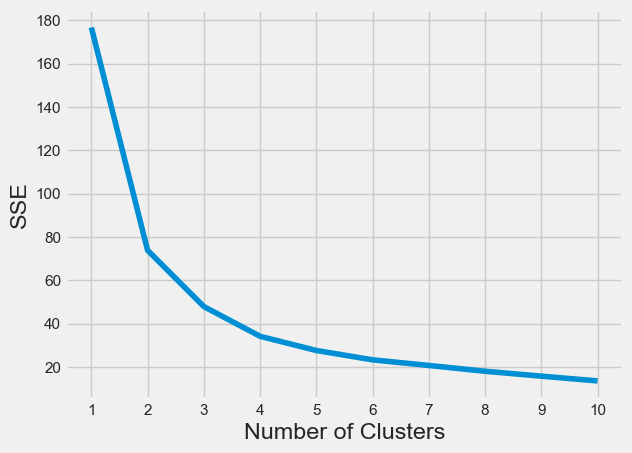

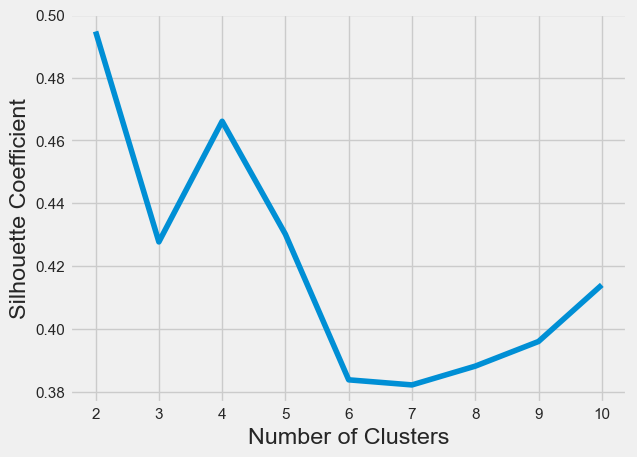

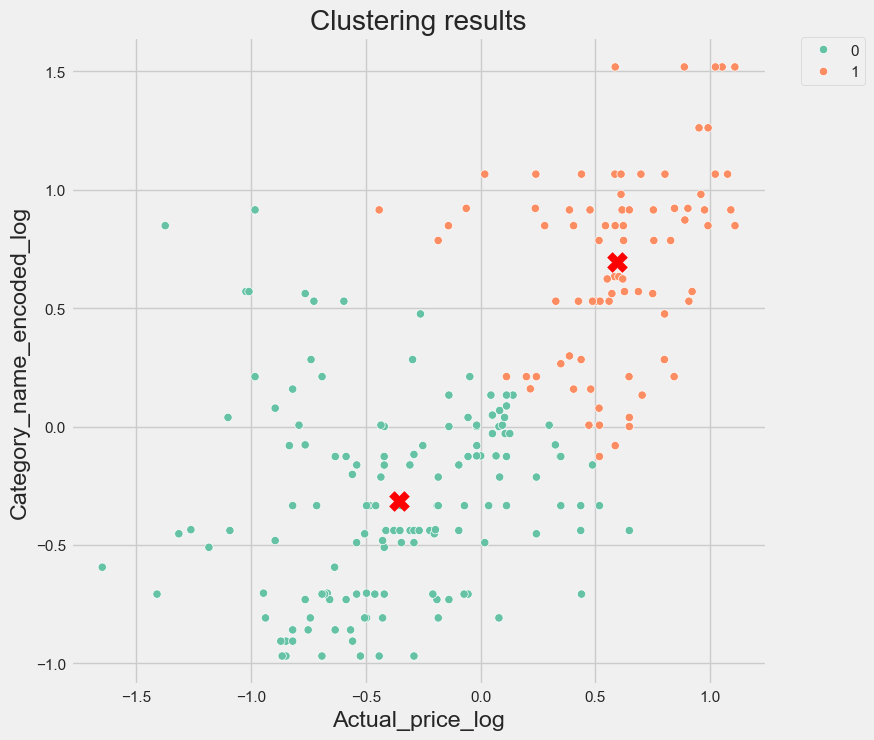

In [73]:
df = pd.read_csv('./../datasets/reduced_electronic_products.csv')
main_process(df)